In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'CS231n/assessment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/CS231n/assessment1/cs231n/datasets
/content/drive/My Drive/CS231n/assessment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cs231n.features import *

# num_color_bins = 10 # Number of bins in the color histogram
num_color_bins = 25 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train Softmax classifier on features
Using the Softmax code developed earlier in the assignment, train Softmax classifiers on top of the features extracted above; this should achieve better results than training them directly on top of raw pixels.

In [8]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import Softmax

learning_rates = [1e-7, 1e-6]
regularization_strengths = [5e5, 5e6]

results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. If you carefully tune the model, #
# you should be able to get accuracy of above 0.42 on the validation set.      #
################################################################################

# 定义训练参数
num_iters = 2000  # 你可以根据需要调整
batch_size = 200

# 遍历所有超参数组合 (网格搜索)
for lr in learning_rates:
    for reg in regularization_strengths:
        # 1. 初始化一个新的 Softmax 实例
        softmax = Softmax()

        # 2. 使用特征数据进行训练
        # (假设 y_train 已经在环境中)
        softmax.train(X_train_feats, y_train,
                      learning_rate=lr,
                      reg=reg,
                      num_iters=num_iters,
                      batch_size=batch_size,
                      verbose=False) # 搜索时关闭详细输出

        # 3. 在训练集特征上评估
        y_train_pred = softmax.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)

        # 4. 在验证集特征上评估
        # (假设 y_val 已经在环境中)
        y_val_pred = softmax.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)

        # 5. 存储结果
        results[(lr, reg)] = (train_accuracy, val_accuracy)

        # 6. 检查并保存最佳模型
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax # 保存这个表现最好的分类器

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

/content/drive/My Drive/CS231n/assessment1/cs231n/classifiers/softmax.py:37: RuntimeWarning: divide by zero encountered in log
  loss = np.mean(-np.log(probs[np.arange(N), y])) + reg * np.sum(W * W)
/content/drive/My Drive/CS231n/assessment1/cs231n/classifiers/softmax.py:37: RuntimeWarning: overflow encountered in scalar multiply
  loss = np.mean(-np.log(probs[np.arange(N), y])) + reg * np.sum(W * W)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/content/drive/My Drive/CS231n/assessment1/cs231n/classifiers/softmax.py:37: RuntimeWarning: overflow encountered in multiply
  loss = np.mean(-np.log(probs[np.arange(N), y])) + reg * np.sum(W * W)
/content/drive/My Drive/CS231n/assessment1/cs231n/classifiers/softmax.py:41: RuntimeWarning: overflow encountered in multiply
  dW = X.T.dot(dp) / N + 2.0 * reg * W


lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.417041 val accuracy: 0.424000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.348408 val accuracy: 0.349000
lr 1.000000e-06 reg 5.000000e+05 train accuracy: 0.323000 val accuracy: 0.301000
lr 1.000000e-06 reg 5.000000e+06 train accuracy: 0.100265 val accuracy: 0.087000
best validation accuracy achieved: 0.424000


In [9]:
# Evaluate your trained Softmax on the test set: you should be able to get at least 0.42
y_test_pred = best_softmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.404


In [10]:
# Save best softmax model
best_softmax.save("best_softmax_features.npy")

best_softmax_features.npy saved.


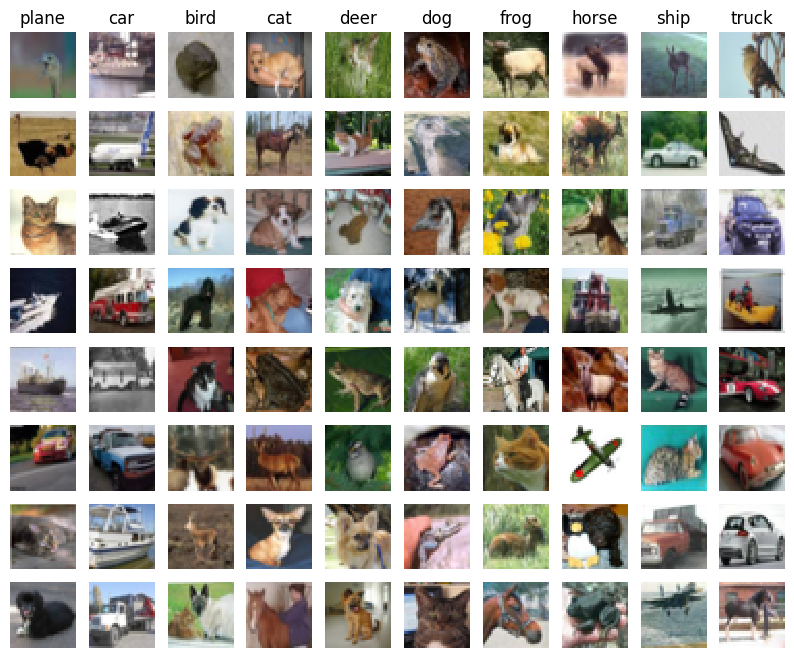

In [11]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ There exists a lot of mistakes of the image classification, for example, the dog is recongized as bird, and apart from that, the accuracy of the network is not stable at all.





## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [12]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 170)
(49000, 169)


In [13]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################

best_val_acc = -1.0
results = {}

# --- 定义超参数搜索范围 ---
# 我们将使用随机搜索。
num_trials = 30  # 你可以增加这个数字以获得更好的结果

# 因为特征数据是规范化的，我们可以尝试稍高的学习率
# 学习率 (lr) 范围: 10^-3.5 (~3e-4) 到 10^-1 (0.1)
lr_range = [-3.5, -1.0]

# 正则化强度 (reg) 范围: 10^-5 到 10^-1
reg_range = [-5, -1]

# 隐藏层大小 (hs) 范围: [200, 700] (在用户设置的500附近)
hs_range = [200, 700]

print(f"Starting random search for {num_trials} trials...")

for i in range(num_trials):
    # 1. 随机采样超参数
    lr = 10**np.random.uniform(lr_range[0], lr_range[1])
    reg = 10**np.random.uniform(reg_range[0], reg_range[1])
    hidden_dim = np.random.randint(hs_range[0], hs_range[1])

    # 2. 创建模型
    # 使用 1e-3 的 weight_scale 是一个安全的选择
    net = TwoLayerNet(input_dim, hidden_dim, num_classes,
                      weight_scale=1e-3, reg=reg)

    # 3. 创建 Solver 并训练
    # 我们可以使用 'adam' 优化器，它通常更快收敛且对学习率不太敏感
    # 或者坚持使用 'sgd'
    solver = Solver(net, data,
                    update_rule='sgd',
                    optim_config={
                        'learning_rate': lr,
                    },
                    lr_decay=0.95,
                    num_epochs=30,  # 在特征上训练，可以增加 epoch
                    batch_size=200,
                    verbose=False) # 在搜索时关闭详细输出

    solver.train()

    # 4. 获取最佳验证准确率
    val_acc = solver.best_val_acc

    # 5. 存储结果
    results[(lr, reg, hidden_dim)] = val_acc

    print(f"Trial {i+1}/{num_trials}: lr={lr:.1e}, reg={reg:.1e}, hs={hidden_dim} ==> val_acc: {val_acc:.4f}")

    # 6. 检查这是否是迄今为止最好的模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_net = net  # 关键：存储训练好的模型对象

# --- 搜索结束 ---

print("\n-------------------------------------------------")
print("Hyperparameter search finished.")
print(f"Best validation accuracy achieved: {best_val_acc:.4f}")

# 找到并打印最佳超参数组合
best_params_combo = max(results, key=results.get)
print(f"Best hyperparameters (lr, reg, hs): {best_params_combo}")
print("-------------------------------------------------")

Starting random search for 30 trials...
Trial 1/30: lr=3.1e-03, reg=1.2e-05, hs=365 ==> val_acc: 0.2750
Trial 2/30: lr=3.1e-02, reg=1.9e-02, hs=208 ==> val_acc: 0.5250
Trial 3/30: lr=1.0e-02, reg=6.8e-03, hs=448 ==> val_acc: 0.4860
Trial 4/30: lr=2.0e-02, reg=2.1e-05, hs=532 ==> val_acc: 0.5240
Trial 5/30: lr=2.7e-02, reg=4.7e-05, hs=358 ==> val_acc: 0.5360
Trial 6/30: lr=6.1e-02, reg=1.8e-05, hs=485 ==> val_acc: 0.5920
Trial 7/30: lr=9.8e-03, reg=1.4e-05, hs=574 ==> val_acc: 0.4920
Trial 8/30: lr=1.2e-03, reg=1.6e-05, hs=685 ==> val_acc: 0.3040
Trial 9/30: lr=6.4e-03, reg=9.0e-02, hs=288 ==> val_acc: 0.3050
Trial 10/30: lr=7.4e-03, reg=1.1e-05, hs=415 ==> val_acc: 0.4430
Trial 11/30: lr=1.1e-03, reg=2.8e-02, hs=591 ==> val_acc: 0.2230
Trial 12/30: lr=9.0e-03, reg=5.1e-03, hs=687 ==> val_acc: 0.4680
Trial 13/30: lr=3.4e-04, reg=3.1e-03, hs=248 ==> val_acc: 0.1110
Trial 14/30: lr=3.2e-02, reg=1.4e-02, hs=495 ==> val_acc: 0.5230
Trial 15/30: lr=8.0e-04, reg=2.7e-03, hs=558 ==> val_acc: 0

In [14]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 58% accuracy. It is also possible to get >60% accuracy
# with careful tuning.
y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.565


In [15]:
# Save best model
best_net.save("best_two_layer_net_features.npy")

best_two_layer_net_features.npy saved.
